Importing Libraries

In [1]:
import tensorflow as tf
import os
import shutil
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from pathlib import Path
import re
import cv2
import glob
from keras import backend as K
tf.__version__

#check if tensorflow gpu is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("tensorflow version:", tf.__version__)

Num GPUs Available:  1
tensorflow version: 2.8.0


Data Preprocessing

In [ ]:
# #USED ONLY FOR CREATING THE DATASET (ONLY DONE ONCE)

# BASE_RAW = 'C:/Users/abhip/Desktop/School/Robotic LUS/model_creation/data/clarius_V2_frames/'
# BASE_NEW = 'C:/Users/abhip/Desktop/School/Robotic LUS/model_creation/data/V2_dataset'
# ANNOTATIONS = 'C:/Users/abhip/Desktop/School/Robotic LUS/model_creation/data/project-4-at-2022-09-06-15-27-21bd68eb' 


# trainX_length = 0
# for dirpath, dirs, files in os.walk(BASE_RAW):
#     if dirpath.__contains__("Labels"):
#         break
#     for file in files:
#         if file.__contains__("Frame"):
#             folderName = os.path.basename(file)
#             # print(folderName)
#             folderName = folderName[5:-4]
#             # print(folderName),
#             newDirName = BASE_NEW + "/" + folderName
#             image_folder = "{}/image/".format(newDirName)
#             mask_folder = "{}/mask/".format(newDirName)
#             dark_folder = '{}dark/'.format(mask_folder)
#             light_folder = '{}light/'.format(mask_folder)
#             # print(newDirName)

#             #creating the folders
#             os.makedirs(newDirName, mode = 0o666, exist_ok=True)
#             os.makedirs(image_folder, mode = 0o666, exist_ok=True)
#             os.makedirs(mask_folder, mode = 0o666, exist_ok=True)
#             os.makedirs(dark_folder, mode = 0o666, exist_ok=True)
#             os.makedirs(light_folder, mode = 0o666, exist_ok=True)
            

#             #copying the image file into the folders
#             old_source = "{}/{}".format(dirpath, file)
#             target_source = "{}/{}".format(image_folder,file)
#             shutil.copyfile(old_source, target_source) 
#             # print(dirpath)
#             trainX_length+=1

# #copying mask files into designated folders
# for dirpath, dirs, files in os.walk(ANNOTATIONS):
#     for file in files:
#         # stringLocation = re.search('.*frame\d',file).group(0) #searhes and extracts the specific file name (up until a certain desired point)
#         stringLocation = re.search('[0-9]+',file).group(0) 
#         IdealLocation = int(stringLocation) - 978
#         if file.__contains__("Dark"):
#             target_source =  "{}/{}/mask/dark/{}".format(BASE_NEW, IdealLocation, file)
#         else:
#             target_source = "{}/{}/mask/light/{}".format(BASE_NEW, IdealLocation, file)
#         old_source = "{}/{}".format(dirpath, file)
#         shutil.copyfile(old_source, target_source) 

# print("done")

Resizing training images and masks


100%|██████████| 722/722 [00:40<00:00, 17.71it/s]


Done!


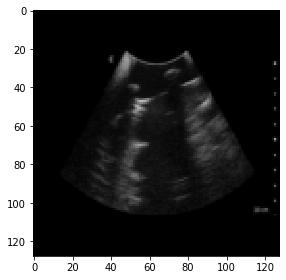

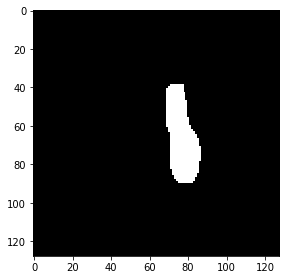

In [2]:
#IMAGE DATASET PRE-PROCESSING

#Set Random Seed
seed = 42
np.random.seed = seed
 
TRAIN_PATH = '../dataset'

#Image parameters 128x128x3
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1 #originally 3

#get the folder names(filename), and creates a tuple
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids =  next(os.walk(TEST_PATH))[1]

#Create Empty Arrays to store images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

#Read all the images and resize them
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    h, w = IMG_HEIGHT, IMG_WIDTH
    img = imread(path + '/image/' + "Frame" + id_ + '.jpg')[:,:,:IMG_CHANNELS]

    #Image resizing to lower resolution
    img = resize(img, (h, w), mode='constant', preserve_range=True)
    X_train[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for _, _, mask_file in os.walk(path + '/mask/dark/'):
        mask_ = imread(path + '/mask/dark/' + mask_file[0])
        mask_ = resize(mask_, (h, w , 1), mode='constant', preserve_range=True)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

print('Done!')
#Test Display|
image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [3]:
# #Link 1: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation 
# #Link 2: https://www.kaggle.com/babbler/mnist-data-augmentation-with-elastic-distortion 

# import numpy as np
# from scipy.ndimage import map_coordinates
# from scipy.ndimage import gaussian_filter

# index2 = 10

# def elastic_transform(image, alpha_range, sigma_range, random_state=None):
#     """Elastic deformation of images as described in [Simard2003]_.
#     .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
#        Convolutional Neural Networks applied to Visual Document Analysis", in
#        Proc. of the International Conference on Document Analysis and
#        Recognition, 2003.
       
#    # Arguments
#        image: Numpy array with shape (height, width, channels). 
#        alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
#            Controls intensity of deformation.
#        sigma: Float, sigma of gaussian filter that smooths the displacement fields.
#        random_state: `numpy.random.RandomState` object for generating displacement fields.
#     """
    
#     if random_state is None:
#         random_state = np.random.RandomState(None)
        
#     if np.isscalar(alpha_range):
#         alpha = alpha_range
#     else:
#         alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])
    
#     if np.isscalar(sigma_range):
#         sigma = sigma_range
#     else:
#         sigma = np.random.uniform(low=sigma_range[0], high=sigma_range[1])

#     shape = image.shape
#     dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
#     dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

#     x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
#     indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

#     return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# # print(X_train[index].shape)
# # transformed_sample_X = elastic_transform(X_train[index2], alpha_range= 1, sigma_range=[0,5])
# # transformed_sample_Y = elastic_transform(Y_train[index2], alpha_range= 1, sigma_range=[0,5])

# # imshow(X_train[index2])
# # plt.show()
# # imshow(Y_train[index2])
# # plt.show()
# # imshow(transformed_sample_X)
# # plt.show()
# # imshow(transformed_sample_Y)
# # plt.show()

In [4]:
# #Data Augmentation
# #link: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/ 
# #link 2: https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844 

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# aug = ImageDataGenerator(rotation_range=10, preprocessing_function=lambda x: elastic_transform(x, alpha_range= 1, sigma_range=[0,5]),
# 	horizontal_flip=True, fill_mode="nearest")

In [5]:
#Training/Validation Split

# print(len(X_train))
X_train = X_train[:int(X_train.shape[0]*0.9)]
print(len(X_train))
Y_train = Y_train[:int(Y_train.shape[0]*0.9)]
print(len(Y_train))
X_val = X_train[:int(X_train.shape[0]*0.1)]
Y_val = Y_train[:int(Y_train.shape[0]*0.1)]

649
649


In [6]:
#Check size of training dataset
print(len(X_train))
print(len(Y_train))

649
649


Developing the Model

In [7]:
def myDiceLoss(y_true, y_pred):
   my_intersection = K.sum(tf.cast(y_pred, dtype=tf.float32) * tf.cast(y_true, dtype=tf.float32))
   my_union = K.sum(tf.cast(y_pred, dtype=tf.float32))+K.sum(tf.cast(y_true, dtype=tf.float32))
   my_smooth = 1
   my_dice = K.mean((2. * my_intersection + my_smooth)/(my_union + my_smooth)) 
   return 1-my_dice

In [8]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [9]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [10]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(tf.cast(y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32)))
    sum_ = K.sum(K.abs(tf.cast(y_true, dtype=tf.float32)) + K.abs(tf.cast(y_pred, dtype=tf.float32)))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [11]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [12]:
#define the input layer

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

#convert each pixel integer into a floating point
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#contraction path (start with feature selection of 16 with 3,3 kernel)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
#Outputs
outputs = tf.keras.layers.Conv2D(1, (1,1), activation= 'sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


#useful link for hyperparameter tuning: https://www.kaggle.com/weilinku/modified-u-net-model-with-hyperparameter-tuning

lr = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.01, staircase=True)

#DIFFERENT COMPILERS

#Baseline
# model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy']) # average dice = 0.63/0.46 (withoutAugmentation)/(withAugmentation) 

#just learning rate 
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics=['accuracy']) #average dice = 0.53 with lr=1e-4 (withoutAugmentation)/(withAugmentation)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics=['accuracy']) #average dice = 0.56 with lr=1e-3 (withoutAugmentation)/(withAugmentation)

#learning rate schedule
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss = 'binary_crossentropy', metrics=['accuracy']) #average dice =0.53  with lr=1e-4, decay_rate=0.01 (withoutAugmentation)/(withAugmentation)

#Changing loss function
model.compile(optimizer= 'adam', loss = bce_dice_loss, metrics=['accuracy', dice_coeff]) # average dice = 0.69/0.58 (withoutAugmentation)/(withAugmentation)
# model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr), loss = bce_dice_loss, metrics=['accuracy', dice_coeff]) # average dice = 0.61 (withoutAugmentation)/(withAugmentation)
# model.compile(optimizer= 'adam', loss = cat_dice_loss, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Model Fitting

In [13]:
#Model Checkpoint
# checkpointer = tf.keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

#Model Callbacks
callbacks = [
   tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
   tf.keras.callbacks.TensorBoard(log_dir='logs')
]

BS = 4
EPOCHS = 100

#WITH/WITHOUT DATA AUGMENTATION

# results = model.fit(aug.flow(X_train, Y_train, batch_size = BS), validation_data=(X_val, Y_val), steps_per_epoch= (len(X_train)/BS), epochs=EPOCHS, callbacks=callbacks)
results = model.fit(X_train,Y_train, validation_data=(X_val, Y_val), batch_size=4, epochs=100, callbacks=callbacks)

Epoch 1/100
163/163 [==============================] - 20s 40ms/step - loss: 0.8110 - accuracy: 0.9351 - dice_coeff: 0.3866 - val_loss: 0.3455 - val_accuracy: 0.9706 - val_dice_coeff: 0.7517
Epoch 2/100
163/163 [==============================] - 3s 20ms/step - loss: 0.4501 - accuracy: 0.9660 - dice_coeff: 0.6564 - val_loss: 0.2520 - val_accuracy: 0.9770 - val_dice_coeff: 0.8279
Epoch 3/100
163/163 [==============================] - 3s 21ms/step - loss: 0.3735 - accuracy: 0.9725 - dice_coeff: 0.7172 - val_loss: 0.2920 - val_accuracy: 0.9675 - val_dice_coeff: 0.8167
Epoch 4/100
163/163 [==============================] - 3s 20ms/step - loss: 0.3138 - accuracy: 0.9768 - dice_coeff: 0.7631 - val_loss: 0.2106 - val_accuracy: 0.9794 - val_dice_coeff: 0.8562
Epoch 5/100
163/163 [==============================] - 3s 20ms/step - loss: 0.3063 - accuracy: 0.9777 - dice_coeff: 0.7696 - val_loss: 0.1935 - val_accuracy: 0.9821 - val_dice_coeff: 0.8652
Epoch 6/100
163/163 [============================

Save Model

In [14]:
#Save the Model
model.save("dark_features_greyscale")

INFO:tensorflow:Assets written to: dark_features_greyscale\assets


Showing Results

In [15]:
print(results.history.keys())

dict_keys(['loss', 'accuracy', 'dice_coeff', 'val_loss', 'val_accuracy', 'val_dice_coeff'])


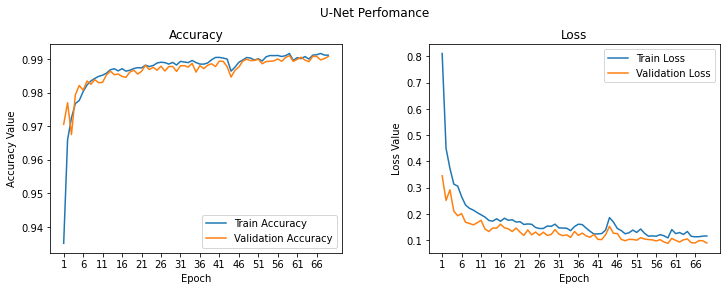

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('U-Net Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

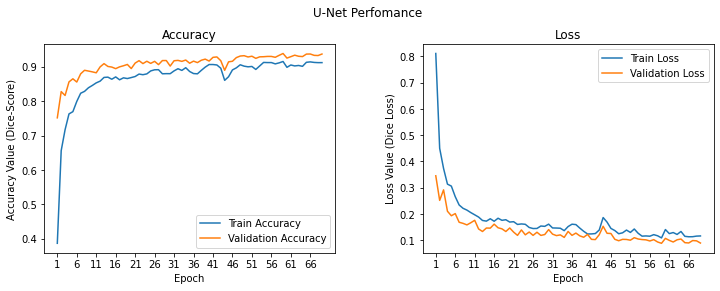

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('U-Net Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results.history['dice_coeff'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results.history['dice_coeff'], label='Train Accuracy')
ax1.plot(epoch_list, results.history['val_dice_coeff'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value (Dice-Score)')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value (Dice Loss)')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
#Credit (Website): https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 
#Credit (Github): https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb 
#Credit for adding colorbar: https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot

from mpl_toolkits.axes_grid1 import make_axes_locatable


preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
# preds_test = model.predict(X_test, verbose=1)

#applying a threshold as every pixel has a probability value from 0-1
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    img1 = ax[0].imshow(X[ix, ..., 0], cmap = 'gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Raw Image')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(img1, cax=cax, orientation ='vertical')

    img2 = ax[1].imshow(y[ix].squeeze(), cmap = 'binary_r')
    ax[1].set_title('Manual Segmentation')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(img2, cax=cax, orientation ='vertical')
    
    
    img3 = ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap = 'Blues')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Segmentation')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(img3, cax=cax, orientation ='vertical')
    
    img4 = ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap = 'Blues')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Segmentation Binary')
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(img4, cax=cax, orientation ='vertical')




2/2 [==============================] - 0s 25ms/step


tf.Tensor(0.9411449, shape=(), dtype=float32)
tf.Tensor(0.9411449, shape=(), dtype=float32)


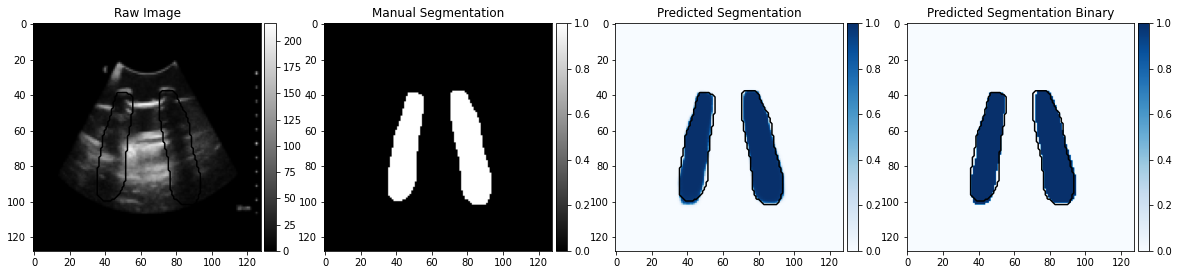

In [19]:
# Check if training data looks all right
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=20)

#References: 
# https://www.tensorflow.org/guide/tensor
# https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2 

#WORKING 
def myDiceScore(y_pred, y_true, index, smoothValue):
   my_intersection = K.sum(np.float32(y_pred[index]) * np.float32(y_true[index]))
   my_union = K.sum(np.float32(y_pred[index]))+K.sum(np.float32(y_true[index]))
   my_smooth = smoothValue
   my_dice = K.mean((2. * my_intersection + my_smooth)/(my_union + my_smooth)) 
   return my_dice

F1_score_20 = myDiceScore(preds_train, Y_train, 20, 1)
print(F1_score_20)
print(dice_coeff(Y_train[20], preds_train[20]))



tf.Tensor(0.93877304, shape=(), dtype=float32)


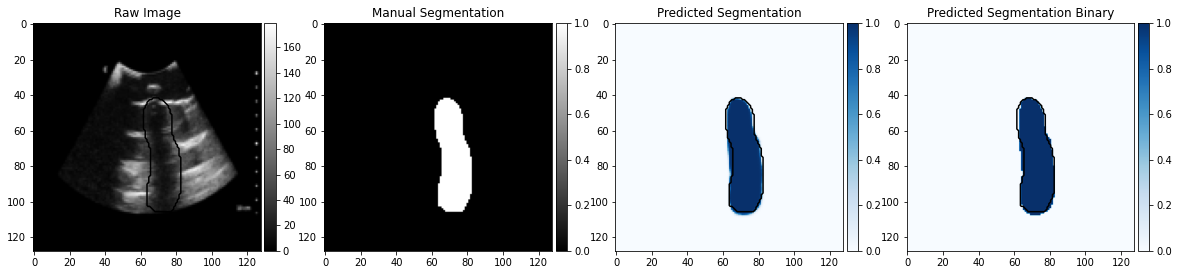

In [20]:
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=150)
F1_score_150 = myDiceScore(preds_train, Y_train, 150, 1)
print(F1_score_150)

tf.Tensor(0.8686239, shape=(), dtype=float32)


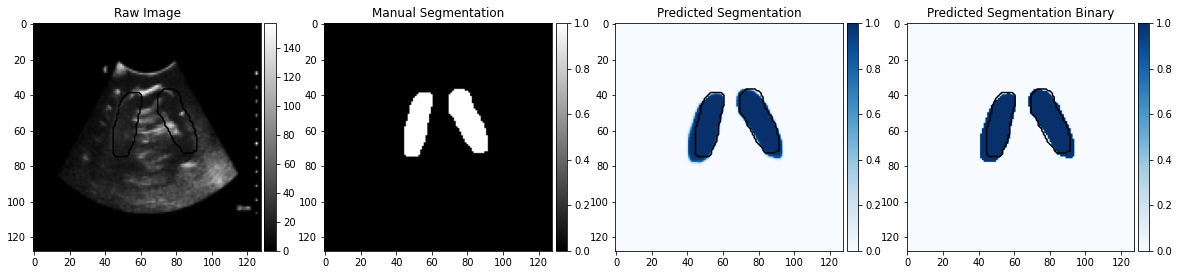

In [21]:
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=200)
F1_score_200 = myDiceScore(preds_train, Y_train, 200, 1)
print(F1_score_200)

tf.Tensor(0.9411449, shape=(), dtype=float32)


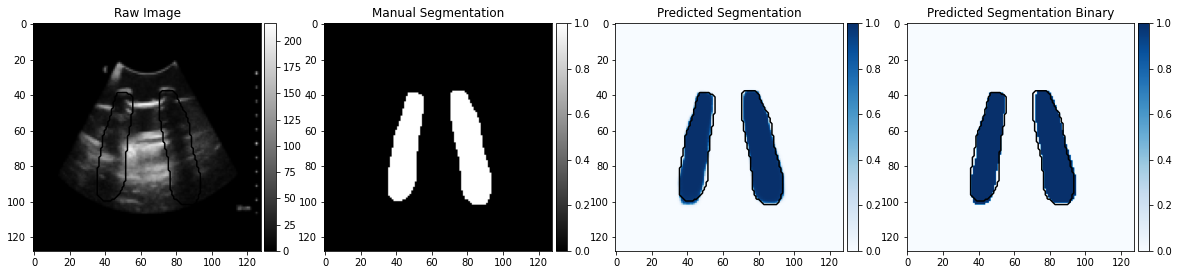

In [22]:
plot_sample(X=X_val, y= Y_val, preds=preds_val, binary_preds=preds_val_t, ix = 20)
F1_score_val_20 = myDiceScore(preds_val, Y_val, 20, 1)
print(F1_score_val_20)

In [23]:
#TOTAL AVERAGED DICE SCORE (TRAIN)
total_dice_array = np.zeros(len(Y_train))
for i in range(0, len(Y_train)):
    total_dice_array[i] = myDiceScore(preds_train, Y_train, i, 1)
    # print(total_dice_array[i]) 

# print(K.sum(total_dice_array))
# print(len(Y_train))

total_avg_dice = K.sum(total_dice_array)/len(Y_train)
print(total_avg_dice)

tf.Tensor(0.8833941170473645, shape=(), dtype=float64)


In [24]:
#TOTAL AVERAGED DICE SCORE (TEST)
total_dice_array = np.zeros(len(Y_val))
for i in range(0, len(Y_val)):
    total_dice_array[i] = myDiceScore(preds_val, Y_val, i, 1)
    # print(total_dice_array[i]) 

# print(K.sum(total_dice_array))
# print(len(Y_train))

total_avg_dice = K.sum(total_dice_array)/len(Y_val)
print(total_avg_dice)

tf.Tensor(0.9372375383973122, shape=(), dtype=float64)


In [25]:
# preds_test_pocovidnet = model.predict(X_test_pocovidnet, verbose=1)

In [26]:
#HARCODED DISPLAY TESTS
# ix = random.randint(0, len(preds_test_pocovidnet))
# imshow(X_test_pocovidnet[ix])
# plt.show()
# imshow(preds_test_pocovidnet[ix], vmin=0, vmax=1, cmap = 'Blues')
# plt.show()

In [27]:
# def plot_test_sample(X, preds, ix=None):
#     """Function to plot the results"""
#     if ix is None:
#         ix = random.randint(0, len(X))

#     fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#     img1 = ax[0].imshow(X[ix], cmap = 'gray')
#     ax[0].set_title('Raw Image')
#     divider = make_axes_locatable(ax[0])
#     cax = divider.append_axes('right', size = '5%', pad = 0.05)
#     fig.colorbar(img1, cax=cax, orientation ='vertical')

#     img2 = ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap = 'Blues')
#     ax[1].set_title('Manual Segmentation')
#     divider = make_axes_locatable(ax[1])
#     cax = divider.append_axes('right', size = '5%', pad = 0.05)
#     fig.colorbar(img2, cax=cax, orientation ='vertical')

In [28]:
# plot_test_sample(X_test_pocovidnet,preds_test_pocovidnet, ix=60)

In [29]:
# plot_test_sample(X_test_pocovidnet,preds_test_pocovidnet, ix=59) #try 28, 29, 40, 47, 59

In [30]:
# plot_test_sample(X_test_pocovidnet,preds_test_pocovidnet, ix=70) #try 28, 29, 40, 47, 59

Displaying Stats on TensorBoard

In [31]:
# %tensorboard --logdir=logs/ --host localhost --port 8088